In [279]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import os

In [297]:
#Download Index data from YahooFinance
indexes = ["^GSPC", "^FTLC", "^HSI", "^N225", "000001.SS", "^SSMI", "^BSESN", "^GDAXI", "^FCHI", "^BVSP"]
all_index_df = pd.DataFrame()
all_index_original_df = pd.DataFrame()
path = "./data/index/"
for index in indexes:
    index_df = yf.download(tickers=index, period="max", interval="1d")
    index_df = index_df.drop(columns=['Open', 'High', 'Low', 'Close'])
    
    # Calculate percentage change for 'Adj Close' and 'Volume'
    index_df['date'] = index_df.index
    index_df['price_change'] = index_df['Adj Close'].pct_change()
    index_df['volume_change'] = index_df['Volume'].pct_change()
    index_df['volatility'] = index_df['Adj Close'].rolling(window=252).std()
    index_df.loc[index_df['Volume'] == 0, 'volume_change'] = 0
    
    #Rename columns
    index_df.rename(columns = {'Adj Close':'price', 'Volume': 'volume'}, inplace = True)

    # Save index data to csv
    index_df.to_csv(path + f"{index}_index.csv", index=False)
    print(f"Saved {index}_index.csv")
    
    index_df['index'] = index
    all_index_df = pd.concat([all_index_df, index_df], ignore_index=True)

# Save aggregated index data to csv
all_index_df.to_csv(path + f"all_index.csv", index=False)
print(f"Saved all_index.csv")
    

[*********************100%***********************]  1 of 1 completed
Saved ^GSPC_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^FTLC_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^HSI_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^N225_index.csv
[*********************100%***********************]  1 of 1 completed
Saved 000001.SS_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^SSMI_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^BSESN_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^GDAXI_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^FCHI_index.csv
[*********************100%***********************]  1 of 1 completed
Saved ^BVSP_index.csv
Saved all_index.csv


## Return

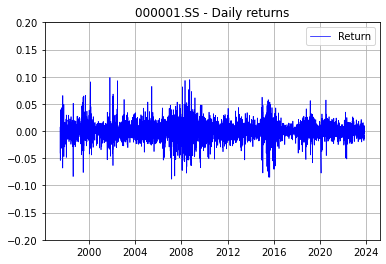

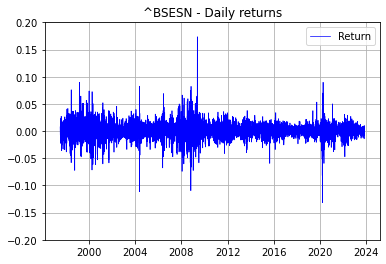

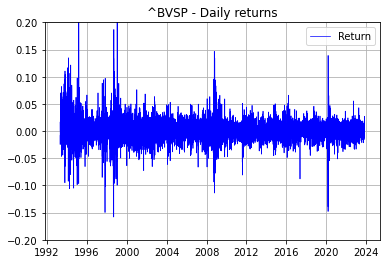

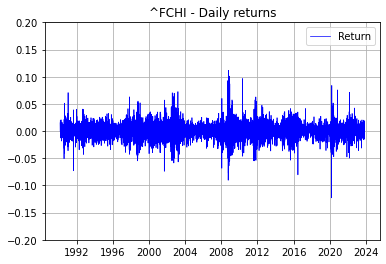

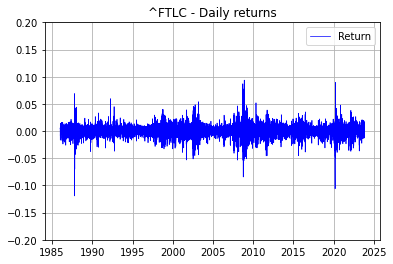

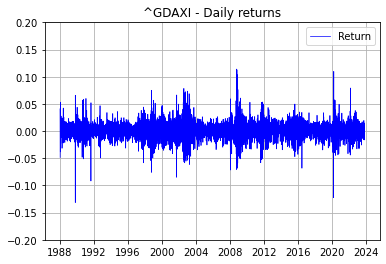

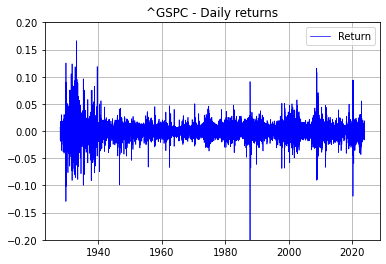

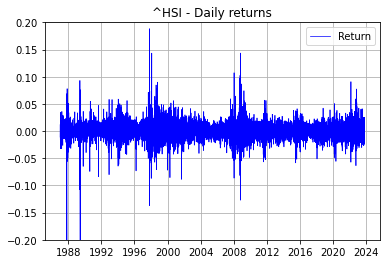

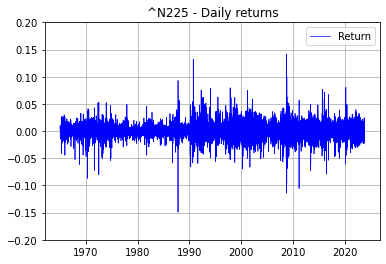

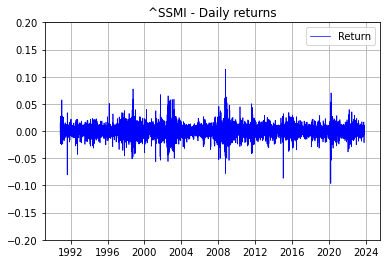

In [298]:
index_grouped = all_index_df.groupby('index')
for name, df in index_grouped:
    df.set_index(df['date'], inplace=True)
    plt.plot(df['price_change'], color='blue', linewidth=0.7)
    plt.ylim(-0.2, 0.2)
    plt.grid()
    plt.legend(['Return'])
    plt.title(name + ' - Daily returns')
    plt.show()

In [299]:
# Autocorrelation: daily return is not a strong predictor for the price change of the following day
for name, df in index_grouped:
    print("Autocorrelation of", name, ": ", df['price_change'].autocorr(lag=1))


Autocorrelation of 000001.SS :  0.01939276573011963
Autocorrelation of ^BSESN :  0.0576163629125943
Autocorrelation of ^BVSP :  0.03163381275630206
Autocorrelation of ^FCHI :  -0.009477312406999068
Autocorrelation of ^FTLC :  0.01040669357289096
Autocorrelation of ^GDAXI :  -0.012147152879951436
Autocorrelation of ^GSPC :  -0.0132711737365413
Autocorrelation of ^HSI :  0.01464490994006931
Autocorrelation of ^N225 :  -0.009857494628181378
Autocorrelation of ^SSMI :  0.03105349828602926


In [300]:
all_index_df

,price,volume,date,price_change,volume_change,volatility,index
0,17.660000,0,1927-12-30,NaN,0.000000,NaN,^GSPC
1,17.760000,0,1928-01-03,0.005663,0.000000,NaN,^GSPC
2,17.719999,0,1928-01-04,-0.002252,0.000000,NaN,^GSPC
3,17.549999,0,1928-01-05,-0.009594,0.000000,NaN,^GSPC
4,17.660000,0,1928-01-06,0.006268,0.000000,NaN,^GSPC
...,...,...,...,...,...,...,...
103615,113144.000000,10557400,2023-10-31,0.005438,0.083722,5837.395328,^BVSP
103616,115053.000000,13904100,2023-11-01,0.016872,0.317000,5838.510054,^BVSP
103617,118160.000000,15714000,2023-11-03,0.027005,0.130170,5846.436462,^BVSP
103618,118487.000000,10167700,2023-11-06,0.002767,-0.352953,5852.885245,^BVSP


## Drawdown
def: total loss over consequtive days from the last maximum to the next minimum of the price

In [338]:
# Create drawdown table
drawdowns_dict = {}
drawdowns_df = []

index_grouped = all_index_df.groupby('index')
for name, index_df in index_grouped:
    index_df.set_index(index_df['date'], inplace=True)
    index_change = index_df['price'].diff()
    drawdowns = []
    drawdown_start = None
    dd = 0
    
    for date, price in zip(index_df.index, index_df['price']):
        if drawdown_start is None and index_change[date] < 0:
            drawdown_start = date
            dd += index_change[date]
        elif drawdown_start is not None and index_change[date] <= 0:
            dd += index_change[date]
        elif drawdown_start is not None and index_change[date] > 0:
            drawdown_end = date
            duration = (drawdown_end - drawdown_start).days
            drawdown = dd / index_df['price'][drawdown_start]
            drawdowns.append((drawdown_start, drawdown_end, duration, drawdown))
            drawdown_start = None
            dd = 0

    # Convert drawdowns list to DataFrame
    drawdowns_df = pd.DataFrame(drawdowns, columns=['drawdown_start', 'drawdown_end', 'duration', 'drawdown'])
    drawdowns_df = drawdowns_df.sort_values(by='drawdown')
    drawdowns_dict[name] = drawdowns_df

print(drawdowns_dict)

{'000001.SS':      drawdown_start drawdown_end  duration  drawdown
1075     2015-08-20   2015-08-27         7 -0.236559
642      2008-06-03   2008-06-16        13 -0.171762
1067     2015-07-01   2015-07-06         5 -0.145622
1066     2015-06-25   2015-06-30         5 -0.140714
663      2008-09-26   2008-10-13        17 -0.129449
...             ...          ...       ...       ...
924      2012-12-19   2012-12-20         1 -0.000104
1148     2016-08-29   2016-08-30         1 -0.000092
1157     2016-10-20   2016-10-21         1 -0.000085
386      2004-02-19   2004-02-20         1 -0.000047
809      2011-02-25   2011-02-28         3 -0.000013

[1597 rows x 4 columns], '^BSESN':      drawdown_start drawdown_end  duration  drawdown
635      2008-10-22   2008-10-29         7 -0.213751
637      2008-11-11   2008-11-21        10 -0.211912
633      2008-10-03   2008-10-13        10 -0.201801
590      2008-01-14   2008-01-23         9 -0.197679
160      2000-04-12   2000-04-25        13 -0.189

In [339]:
# Save drawdown to csv 
all_drawdowns_df = pd.DataFrame()
path = "./data/crashes/"
for index, drawdowns_df in drawdowns_dict.items():
    all_drawdowns_df = pd.concat([all_drawdowns_df, drawdowns_df.assign(index=index)], ignore_index=True)

all_drawdowns_df.to_csv(path + f"all_drawdowns.csv", index=False)
print(f"Saved all_drawdowns.csv")

Saved all_drawdowns.csv


## Crashes
- 99.5% percentile of drawdowns

In [343]:
# Crash Identification
crashes_dict = {}
for index, dd in drawdowns_dict.items():
    crash_threshold = dd['drawdown'].iloc[round(dd.shape[0] * 0.005)]
    crash_df = dd[dd['drawdown'] < crash_threshold]
    crash_df.columns = ['crash_start', 'crash_end', 'duration','drawdown']
    crashes_dict[index] = crash_df

print(crashes_dict)

{'000001.SS':      crash_start  crash_end  duration  drawdown
1075  2015-08-20 2015-08-27         7 -0.236559
642   2008-06-03 2008-06-16        13 -0.171762
1067  2015-07-01 2015-07-06         5 -0.145622
1066  2015-06-25 2015-06-30         5 -0.140714
663   2008-09-26 2008-10-13        17 -0.129449
13    1997-09-22 1997-09-24         2 -0.129130
665   2008-10-21 2008-10-28         7 -0.127981
619   2008-01-21 2008-01-23         2 -0.126314, '^BSESN':      crash_start  crash_end  duration  drawdown
635   2008-10-22 2008-10-29         7 -0.213751
637   2008-11-11 2008-11-21        10 -0.211912
633   2008-10-03 2008-10-13        10 -0.201801
590   2008-01-14 2008-01-23         9 -0.197679
160   2000-04-12 2000-04-25        13 -0.189888
1300  2020-03-16 2020-03-20         4 -0.185258
382   2004-05-14 2004-05-18         4 -0.176397, '^BVSP':     crash_start  crash_end  duration  drawdown
91   1995-03-02 1995-03-10         8 -0.378910
310  1999-01-07 1999-01-15         8 -0.327006
292  199

In [344]:
# Save crashes to csv 
all_crashes_df = pd.DataFrame()
path = "./data/crashes/"
for index, crashes_df in crashes_dict.items():
    crashes_df.to_csv(path + f"{index}_crahes.csv", index=False)
    print(f"Saved {index}_crashes.csv")
    crashes_df.loc[:, 'index'] = index
    all_crashes_df = pd.concat([all_crashes_df, crashes_df], ignore_index=True)
    
all_crashes_df.to_csv(path + f"all_crashes.csv", index=False)
print(f"Saved all_crashes.csv")

Saved 000001.SS_crashes.csv
Saved ^BSESN_crashes.csv
Saved ^BVSP_crashes.csv
Saved ^FCHI_crashes.csv
Saved ^FTLC_crashes.csv
Saved ^GDAXI_crashes.csv
Saved ^GSPC_crashes.csv
Saved ^HSI_crashes.csv
Saved ^N225_crashes.csv
Saved ^SSMI_crashes.csv
Saved all_crashes.csv


/var/folders/9r/7ktg2zxx2gs716xfvv5vjjpc0000gn/T/ipykernel_12203/2717695831.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_df.loc[:, 'index'] = index
/var/folders/9r/7ktg2zxx2gs716xfvv5vjjpc0000gn/T/ipykernel_12203/2717695831.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_df.loc[:, 'index'] = index
/var/folders/9r/7ktg2zxx2gs716xfvv5vjjpc0000gn/T/ipykernel_12203/2717695831.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [314]:
# Crashes Count
crash_count = 0
for index, crashes_df in crashes.items():
    crash_count += len(crashes_df)
print(crash_count)

107


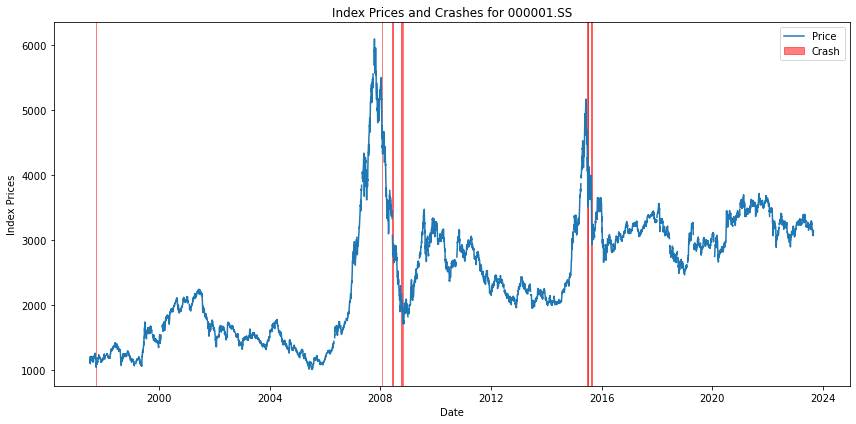

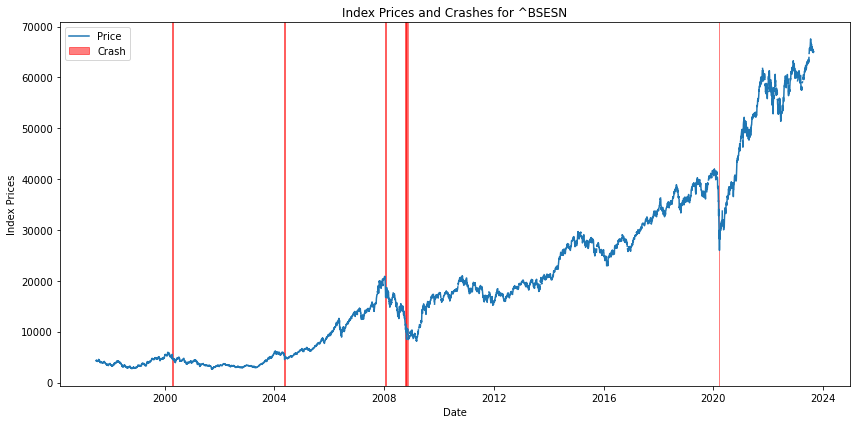

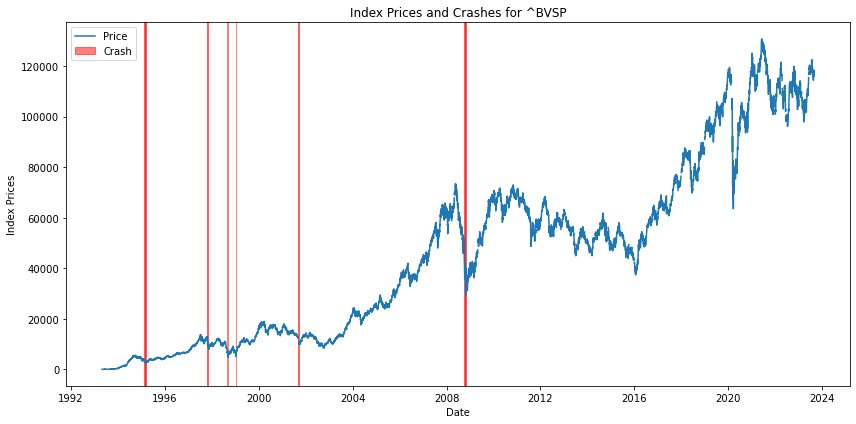

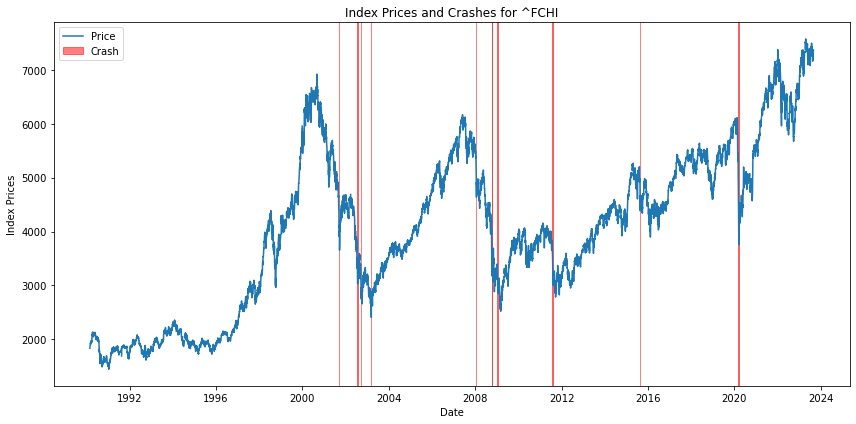

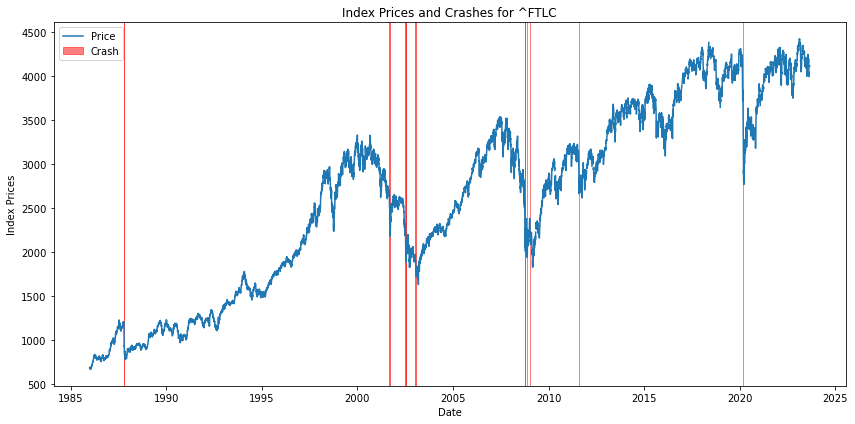

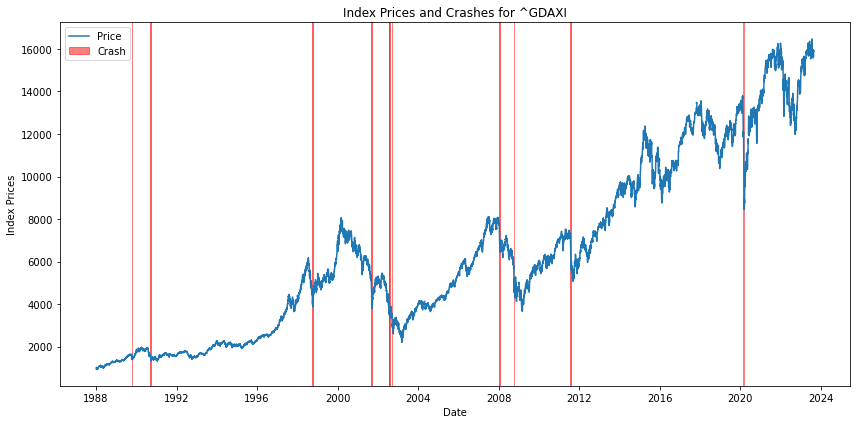

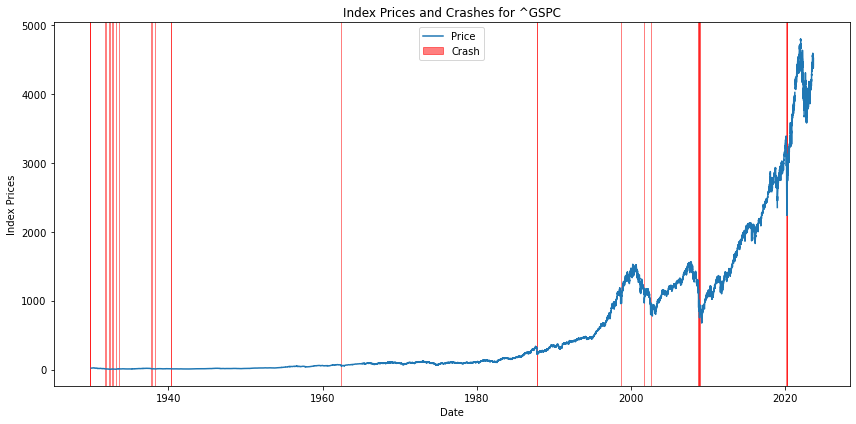

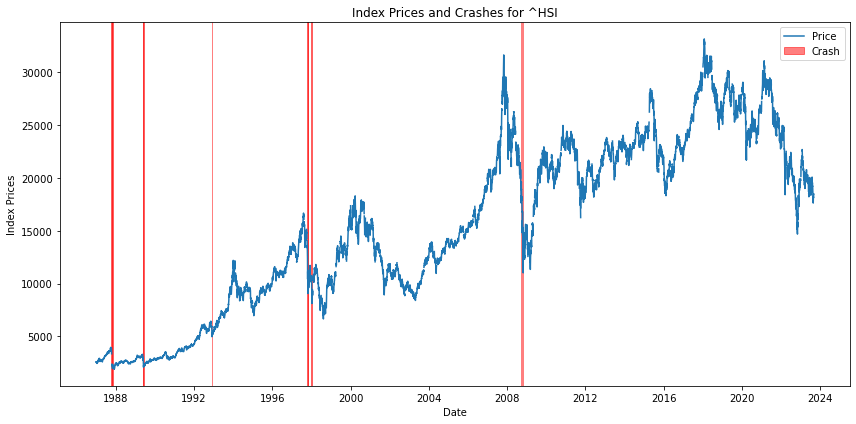

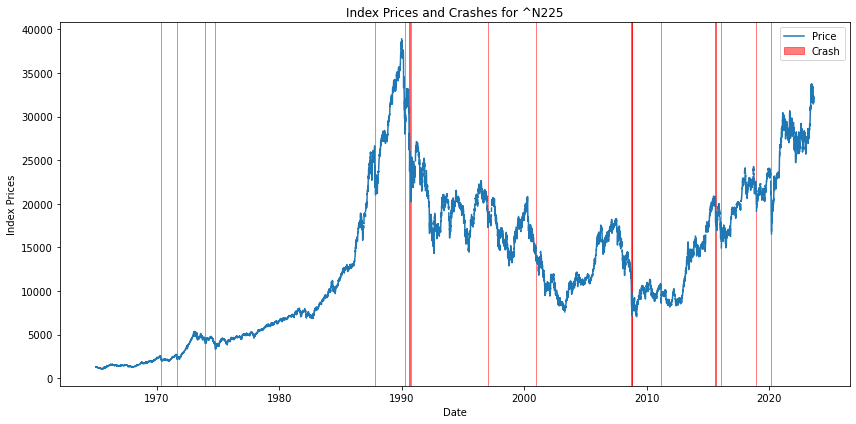

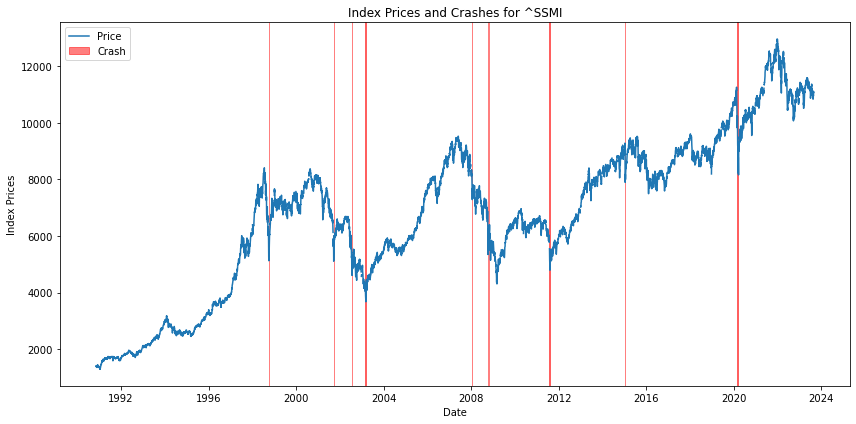

In [315]:
# Plot crashes in graph
for index, crashes_df in crashes_dict.items():
    index_prices = np.array(price_df[index])
    index_dates = np.array(price_df.index)
    plt.figure(figsize=(12, 6))
    plt.plot(index_dates, index_prices, label=f'{index} Prices')
    for crash_start, crash_end in zip(crashes_df['crash_start'], crashes_df['crash_end']):
        plt.axvspan(crash_start, crash_end, alpha=0.5, color='red')
    plt.title(f'Index Prices and Crashes for {index}')
    plt.xlabel('Date')
    plt.ylabel('Index Prices')
    plt.legend(['Price', 'Crash'])
    plt.tight_layout()
    plt.show()

## Label the crashes
- we need to label the crashes to each day using all_index_df and all_crashes_df before training them to ML models

In [317]:
# Convert 'crash_start' and 'crash_end' to datetime objects
all_crashes_df['crash_start'] = pd.to_datetime(all_crashes_df['crash_start'])
all_crashes_df['crash_end'] = pd.to_datetime(all_crashes_df['crash_end'])

# Convert 'Date' to datetime objects
all_index_df['date'] = pd.to_datetime(all_index_df['date'])


In [318]:
# Function to label crashes
def label_crashes(row):
    for index, crash in all_crashes_df.iterrows():
        if crash['crash_start'] <= row['date'] and row['date'] <= crash['crash_end'] and row['index'] == crash['index']:
            return 1
    return 0

# Apply the function to create a new column indicating whether there was a crash
all_index_df['crash_label'] = all_index_df.apply(label_crashes, axis=1)

In [319]:
# View the resulting dataframe
labeled_index_df = all_index_df
labeled_index_df

,price,volume,date,price_change,volume_change,volatility,index,crash_label
0,17.660000,0,1927-12-30,NaN,0.000000,NaN,^GSPC,0
1,17.760000,0,1928-01-03,0.005663,0.000000,NaN,^GSPC,0
2,17.719999,0,1928-01-04,-0.002252,0.000000,NaN,^GSPC,0
3,17.549999,0,1928-01-05,-0.009594,0.000000,NaN,^GSPC,0
4,17.660000,0,1928-01-06,0.006268,0.000000,NaN,^GSPC,0
...,...,...,...,...,...,...,...,...
103615,113144.000000,10557400,2023-10-31,0.005438,0.083722,5837.395328,^BVSP,0
103616,115053.000000,13904100,2023-11-01,0.016872,0.317000,5838.510054,^BVSP,0
103617,118160.000000,15714000,2023-11-03,0.027005,0.130170,5846.436462,^BVSP,0
103618,118487.000000,10167700,2023-11-06,0.002767,-0.352953,5852.885245,^BVSP,0


## Period Adjustment
- Goal: create 1m, 3m and 6m lagged price data for prediction
- To predict a crash on day t, the daily price changes from each day prior to t could be used as a feature

In [320]:
# Label if there is a crash on the day after 1m, 3m and 6m
labeled_index_grouped = labeled_index_df.groupby('index')
lag_labeled_index = pd.DataFrame()
for name, index in labeled_index_grouped:
    index['1m_crash_label'] = index['crash_label'].shift(-21)
    index['3m_crash_label'] = index['crash_label'].shift(-63)
    index['6m_crash_label'] = index['crash_label'].shift(-126)
    lag_labeled_index = pd.concat([lag_labeled_index, index], ignore_index=True)

In [321]:
# Save as csv
lag_labeled_index.to_csv('./data/labeled_data/' + f"labeled_index.csv", index=False)
print(f"Saved labeled_index.csv")

Saved labeled_index.csv


## Dataset imbalances

The rare nature of stock market crash events results in a highly imbalanced dataset. 
Only 0.7% of available sample corresponds to crash events. Imbalanced dataset can influence ML algorithms and biased against the minority class<br>
One of the solutions is apply resampling

In [323]:
print("Total sample size: ", len(all_index_df))
print("Sample size of not crash day: ", all_index_df['crash_label'].value_counts()[0])
print("Sample size of crash day: ", all_index_df['crash_label'].value_counts()[1])
print("Percentage of crash: ", all_index_df['crash_label'].value_counts()[1]/len(all_index_df))

Total sample size:  103620
Sample size of not crash day:  102846
Sample size of crash day:  774
Percentage of crash:  0.007469600463231037
